In [1]:
import numpy as np
import pdb

from functools import reduce
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [2]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest
sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 100000
num_z_samples = 100

# nu is the ratio of noise to data samples in NCE
nu = 1

In [4]:
#observed data
z = rnd.uniform(0,1, n) > 0.5 
x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)) 

#noise
y = sigma0 * rnd.randn(n*nu)

In [5]:
thetas = np.arange(0.01, 8, 0.1)
n_theta = len(thetas)
thetas_small = thetas[5::2]
n_theta_small = len(thetas_small)

# correctly normalised model
pm = lambda u, theta: 0.5*(norm.pdf(u,0,theta)+norm.pdf(u, 0, sigma1))
# noise that matches the larger std
pn = lambda u: norm.pdf(u,0, sigma0) 
# quick hack: generally better to work in log domain!
h = lambda u, theta: np.log(pm(u, theta)/pn(u))

In [6]:
def sample_z(nz, x, y, alpha):
    """produces # samples equal to nz for each element of x & y"""
    zx = np.zeros((nz, len(x)))
    zy = np.zeros((nz, len(y)))
    for j in range(len(x)):
        zx[:,j] = rnd.uniform(0, 1, nz) < q1(x[j], alpha)
    for j in range(len(x)):
        zy[:,j] = rnd.uniform(0, 1, nz) < q1(y[j], alpha)  
    
    return zx, zy  # (nz, len(x)) , (nz, len(y))

In [7]:
eps = 10**-15

#q0 = lambda u, alpha:  1 / (1 + (alpha/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/alpha**2)))
q0 = lambda u, alpha: norm.pdf(u, 0, alpha) / (norm.pdf(u, 0, alpha) + norm.pdf(u, 0, sigma1))
q1 = lambda u, alpha: 1 - q0(u, alpha) 

phi0 = lambda u, theta:  0.5*norm.pdf(u, 0, theta)
phi1 = lambda u, theta:  0.5*norm.pdf(u, 0, sigma1)

r0 = lambda u, theta, alpha: phi0(u, theta)/( q0(u, alpha)*pn(u) + eps)
r1 = lambda u, theta, alpha: phi1(u, theta)/( q1(u, alpha)*pn(u) + eps)

In [8]:
def r(u, z, theta, alpha):
    term1 = (z==0)*r0(u, theta, alpha)
    term2 = (z==1)*r1(u, theta, alpha)
    return term1 + term2

In [9]:
def psi_1(x, z, theta, alpha):
    return 1 + (1 / r(x, z, theta, alpha))

def psi_2(y, z, theta, alpha):
    return 1 + (1/nu)* np.mean(r(y, zy, theta, alpha), axis=0)

def J1_grad(x, y, zx, zy, theta, alpha):
    '''Computes J1_grad as defined in the equations above'''
    a = (psi_1(x, zx, theta, alpha) - 1)/psi_1(x, zx, theta, alpha)
    term_1 = nu*np.mean(a*(-(1/theta) + (x**2/theta**3)))
    
    b = (psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha)
    term_2 = -nu*np.mean(b*(-(1/theta) + (y**2/theta**3)))
    
    return term_1, term_2

In [10]:
degree = 3

def make_poly_design_matrix(u, deg):
    u = u.reshape(-1)
    U = np.zeros((len(u), deg))
    for i in range(deg):
        U[:, i] = u**i  
    return U

def sigmoid(u):
    return  1/(1 + np.exp(-u))

def q0_var(u, w):
    U = make_poly_design_matrix(u, degree)
    return sigmoid(np.dot(U,w))

q1_var = lambda u, w: 1 - q0_var(u, w)
r0_var = lambda u, theta, w: phi0(u, theta)/( q0_var(u, w)*pn(u) + eps)
r1_var = lambda u, theta, w: phi1(u, theta)/( q1_var(u, w)*pn(u) + eps)

In [11]:
def psi_1_0(x, theta, w):
    return 1 + (1/ r0_var(x, theta, w))

def psi_1_1(x, theta, w):
    return 1 + (1/ r1_var(x, theta, w))

def psi_2_analytic(y, theta, w):
    a0 = q0_var(y, w)*r0_var(y,theta, w)
    a1 = q1_var(y, w)*r1_var(y,theta, w)
    return 1 + (1/nu)*(a0 + a1)

def compute_J1_grad_theta(x, y, theta, w):
    '''Computes J1_grad w.r.t theta analytically (no need to sample z's)'''
    # compute the first term
    a0 = (psi_1_0(x, theta, w) - 1)/psi_1_0(x, theta, w)
    a1 = (psi_1_1(x, theta, w) - 1)/psi_1_1(x, theta, w)
    b0 = q0_var(x, w)*(a0)
    b1 = q1_var(x, w)*(a1)
    c = b0 + b1
    term_1 = nu*np.mean(c*(-(1/theta) + (x**2/theta**3)))
    
    # compute the second term
    d = (psi_2_analytic(y, theta, w) - 1)/psi_2_analytic(y, theta, w)
    term_2 = -nu*np.mean(d*(-(1/theta) + (y**2/theta**3)))
    
    # def psi_2(y, z, theta, alpha):
    #     return 1 + (1/nu)* np.mean(r(y, zy, theta, alpha), axis=0)
    # b = (psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha)
    # term_2 = -nu*np.mean(b*(-(1/theta) + (y**2/theta**3)))
    
    return term_1, term_2

In [26]:
def compute_J1_grad_gamma(x, y, theta, w):
    '''Computes J1_grad w.r.t gamma analytically (no need to sample z's)'''
    # compute the first term
    a0 = (psi_1_0(x, theta, w) - 1)/psi_1_0(x, theta, w)
    a1 = (psi_1_1(x, theta, w) - 1)/psi_1_1(x, theta, w)
    b0 = q0_var(x, w)*(a0)
    b1 = q1_var(x, w)*(a1)
    c = b0 + b1
    term_1 = nu*np.mean(c*(np.exp(-2*np.log(theta))*(x**2) - 1))
    
    # compute the second term
    d = (psi_2_analytic(y, theta, w) - 1)/psi_2_analytic(y, theta, w)
    term_2 = -nu*np.mean(d*(np.exp(-2*np.log(theta))*(y**2) - 1))
    
    return (term_1 + term_2)

In [27]:
J1s_mc_1 = np.zeros(n_theta_small)
J1s_mc_2 = np.zeros(n_theta_small)

J1s_analytic_1 = np.zeros(n_theta_small) 
J1s_analytic_2 = np.zeros(n_theta_small) 

J1s_analytic_gamma = np.zeros(n_theta_small)

alpha = 4   
zx, zy = sample_z(num_z_samples, x, y, alpha)

In [28]:
for i in range(n_theta_small):
    theta = thetas_small[i]
    w = np.array([-np.log(alpha), 0, (1/2)*(1-alpha**(-2))])

    J1s_mc_1[i], J1s_mc_2[i] = J1_grad(x, y, zx, zy, theta, alpha)
    J1s_analytic_1[i], J1s_analytic_2[i] = compute_J1_grad_theta(x, y, theta, w)
    
    J1s_analytic_gamma[i] = compute_J1_grad_gamma(x, y, theta, w) 
    
# various debugging print statements
"""print(np.allclose(q0_var(x, w), q0(x, alpha).reshape(-1)))
print(compute_J1(x, y, zx, zy, theta, alpha), compute_J1_analytic(x, y, theta, w))     """
"""    psi_1_anal = q0_var(x, w)*(psi_1_0(x, theta, w)) + q1_var(x, w)*(psi_1_1(x, theta, w))
print(np.mean(psi_1(x, zx, theta, alpha) - psi_1_anal))
print(np.mean(psi_2(y, zy, theta, alpha) - psi_2_analytic(y, theta, w)))
print(np.mean(r0_var(y, theta, w) - r0(y, theta, alpha)))
print(np.mean(r1_var(y, theta, w) - r1(y, theta, alpha)))
"""
"""    psi_1_mc = (psi_1(x, zx, theta, alpha) - 1)/psi_1(x, zx, theta, alpha)
psi_1_anal = q0_var(x, w)*((psi_1_0(x, theta, w) - 1)/psi_1_0(x, theta, w)) + \
q1_var(x, w)*((psi_1_1(x, theta, w) - 1)/psi_1_1(x, theta, w))
print(np.mean(psi_1_mc - psi_1_anal))

psi_2_mc = (psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha)
psi_2_anal = (psi_2_analytic(y, theta, w) - 1)/psi_2_analytic(y, theta, w)
for j in range(0, len(psi_2_anal), 10000):
print(np.mean((psi_2_mc - psi_2_anal)[j:]))"""

'    psi_1_mc = (psi_1(x, zx, theta, alpha) - 1)/psi_1(x, zx, theta, alpha)\npsi_1_anal = q0_var(x, w)*((psi_1_0(x, theta, w) - 1)/psi_1_0(x, theta, w)) + q1_var(x, w)*((psi_1_1(x, theta, w) - 1)/psi_1_1(x, theta, w))\nprint(np.mean(psi_1_mc - psi_1_anal))\n\npsi_2_mc = (psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha)\npsi_2_anal = (psi_2_analytic(y, theta, w) - 1)/psi_2_analytic(y, theta, w)\nfor j in range(0, len(psi_2_anal), 10000):\nprint(np.mean((psi_2_mc - psi_2_anal)[j:]))'

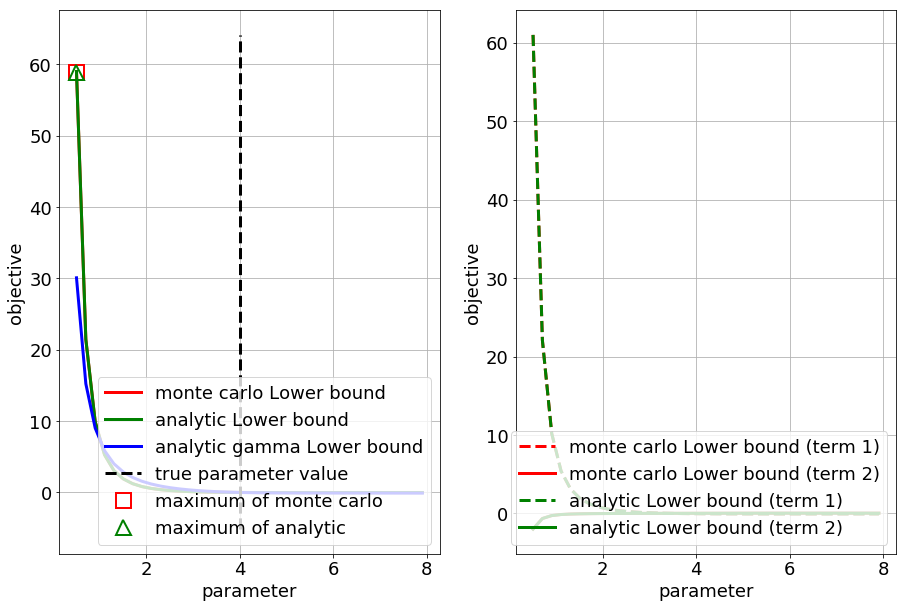

In [32]:
J1s_mc = J1s_mc_1 + J1s_mc_2
J1s_analytic = J1s_analytic_1 + J1s_analytic_2

fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs = axs.ravel()
axs[0].plot(thetas_small, J1s_mc, 'r', label='monte carlo Lower bound')
axs[0].plot(thetas_small, J1s_analytic, 'g', label='analytic Lower bound')
axs[0].plot(thetas_small, J1s_analytic_gamma, 'b', label='analytic gamma Lower bound')
axs[1].plot(thetas_small, J1s_mc_1, 'r--', label='monte carlo Lower bound (term 1)')
axs[1].plot(thetas_small, J1s_mc_2, 'r', label='monte carlo Lower bound (term 2)')
axs[1].plot(thetas_small, J1s_analytic_1, 'g--', label='analytic Lower bound (term 1)')
axs[1].plot(thetas_small, J1s_analytic_2, 'g', label='analytic Lower bound (term 2)')

# true param value
axs[0].plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of lower bound
index1 = np.argmax(J1s_mc)
axs[0].plot(thetas_small[index1], J1s_mc[index1], 'rs', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='r', linestyle='none', label='maximum of monte carlo')

# maximiser of lower bound
index2 = np.argmax(J1s_analytic)
axs[0].plot(thetas_small[index2], J1s_analytic[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='maximum of analytic')

for i in range(2):
    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()

In [30]:
J1s_analytic

array([  5.89872927e+01,   2.14459042e+01,   9.91782752e+00,
         5.27725416e+00,   3.07351300e+00,   1.90406020e+00,
         1.23203288e+00,   8.22068823e-01,   5.60125099e-01,
         3.86528291e-01,   2.68090962e-01,   1.85415647e-01,
         1.26684609e-01,   8.44391442e-02,   5.38283194e-02,
         3.16184553e-02,   1.56097415e-02,   4.27309728e-03,
        -3.49658946e-03,  -8.57023510e-03,  -1.16938955e-02,
        -1.34834179e-02,  -1.44010945e-02,  -1.47700782e-02,
        -1.48068648e-02,  -1.46526992e-02,  -1.43979066e-02,
        -1.40991118e-02,  -1.37909247e-02,  -1.34937085e-02,
        -1.32186934e-02,  -1.29713240e-02,  -1.27534441e-02,
        -1.25647175e-02,  -1.24035474e-02,  -1.22676664e-02,
        -1.21545112e-02,  -1.20614548e-02])

In [31]:
thetas_small

array([ 0.51,  0.71,  0.91,  1.11,  1.31,  1.51,  1.71,  1.91,  2.11,
        2.31,  2.51,  2.71,  2.91,  3.11,  3.31,  3.51,  3.71,  3.91,
        4.11,  4.31,  4.51,  4.71,  4.91,  5.11,  5.31,  5.51,  5.71,
        5.91,  6.11,  6.31,  6.51,  6.71,  6.91,  7.11,  7.31,  7.51,
        7.71,  7.91])